# HW5: Prob 1: Create a 2D embedding of the CIFAR-10 comparing different manifold learning algorithms

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is not that unlike the MNIST data set in that it is is 6K instances of small images. Unlike MNIST they are color images which are 32x32x3 (32 pixels wide, 32 pixels high, 3 color channels). The 3 color channels are red, green and blue. Each pixel is represented by a number between 0 and 255. The data set is divided into 10 classes. The classes are airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. The data set is available in the keras.datasets module. You can load it with the following code:

```python
from torchvision.datasets import CIFAR10
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())
```

Your goal is to compare different manifold learning algorithms on this data set. You should use the following algorithms:

* Principle Component Analysis
* Isomap Embedding
* Locally Linear Embedding
* Multidimensional scaling.
* SpectralEmbedding
* T-distributed Stochastic Neighbor Embedding

All of these algorithms are available in the sklearn library. In addition you should use also try the UMAP algorithm which is available for python as a library [umap](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). In each of these cases you should project the data into 2D and color the data by the class in which it belongs.

Two references which might help the [sklearn documentation](https://scikit-learn.org/stable/modules/manifold.html) and Jake Vanderplas' book [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html).

Practice creating a well formatted Jupyter notebook. You should have a title, a description of the data set, a description of the algorithms, a description of the results, and a discussion of the results. You should also have a conclusion. Your notebook should not have lots of code cells with no explanation. It should also not have lots of text outputs. You may need that during your development but by the time you submit, please clean it up.


In [ ]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=8689bbe8a395d93aaafa4e47569c501bd34e51d5aae73b64505def8cd5473e24
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
pip install --upgrade umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=b0b3aff495095205cf6e1aba471b4fe31366b0436930bf979ba3171890c0c49d
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import cifar10
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
import umap

seed = 99

# **Download the Dataset**

In [5]:
#loading CIFAR-10 Dataset from keras
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#creating dictionary for label outputs
labels = {0:'airplane',1:'automobile',
          2:'bird',3:'cat',4:'deer',
          5:'dog',6:'frog',7:'horse',
          8:'ship',9:'truck'}

Visualization of the first 16 images in the dataset.

<ipython-input-6-28a11e94c103>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i].set(xlabel=labels[int(y_train[i])])


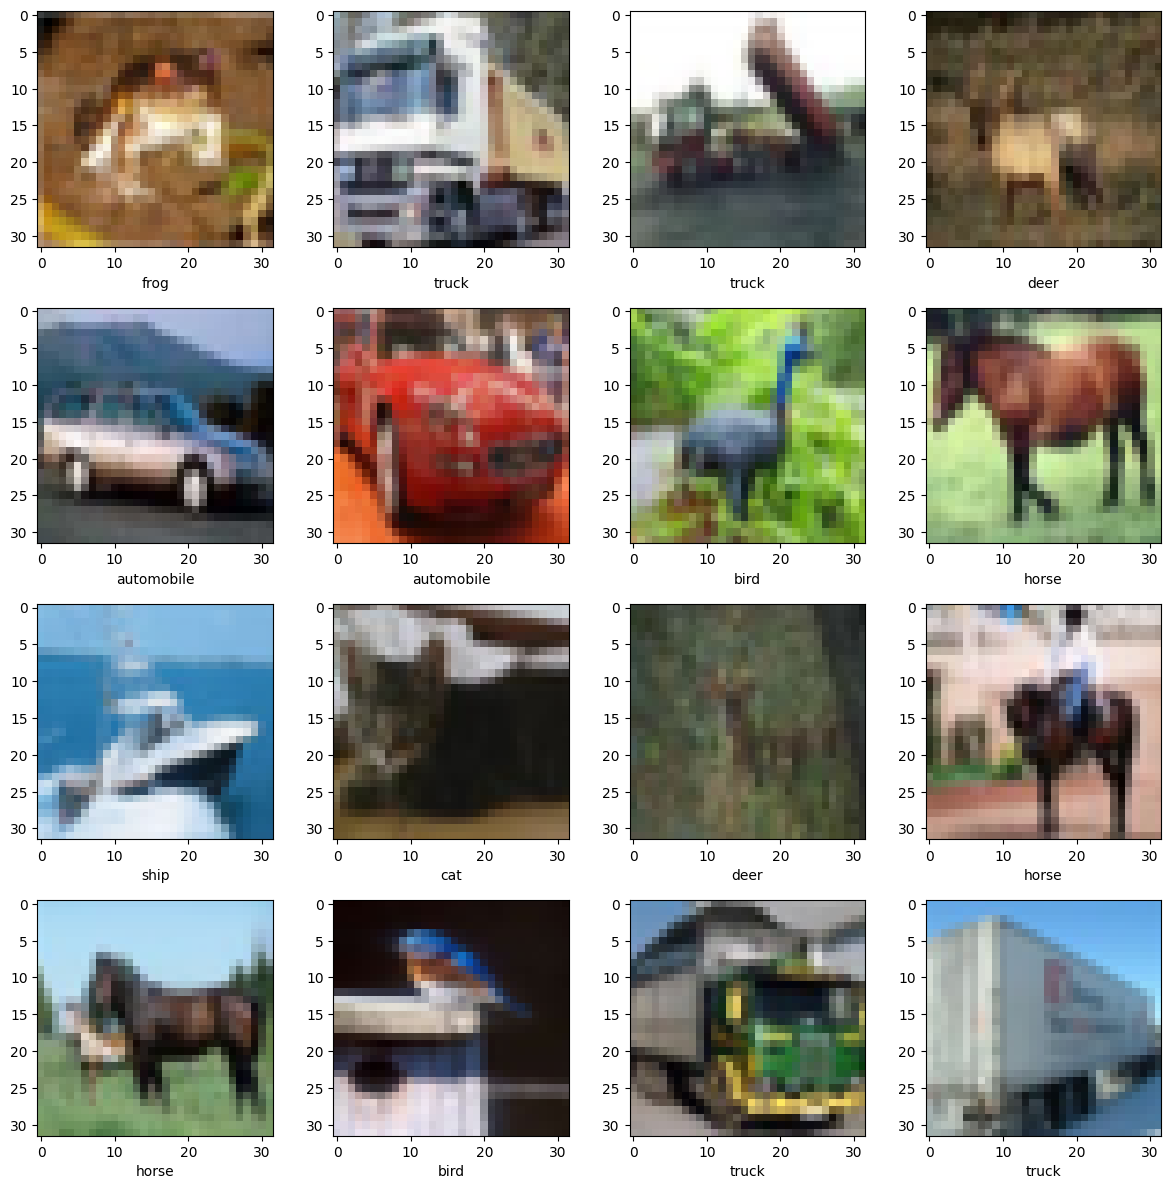

In [6]:
#visualization of dataset
fig,ax=plt.subplots(4,4,figsize=(12,12))
ax=ax.ravel()

for i in range(16):
    ax[i].imshow(X_train[i])
    ax[i].set(xlabel=labels[int(y_train[i])])

plt.tight_layout()

The dataset will need to be reshaped such that the dimensions for each image is transformed from (32,32,3) to (-1,3072). Additionally, the images will be normalized, such that the intensity values for each pixel is between 0 and 1. These preprocessing steps are necessary so that we can fit the models on the data. Note that only certain feature extraction techniques require the images to be normalized, however doing so does not impact the investigation negatively.

In [7]:
#reshaping data
X_train = X_train.reshape(-1,3072)
X_test = X_test.reshape(-1,3072)

#convert y data into numpy array of int
y_train = np.array(list(map(int,y_train)))
y_test = np.array(list(map(int,y_test)))

<ipython-input-7-8601afaad7d9>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = np.array(list(map(int,y_train)))
<ipython-input-7-8601afaad7d9>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = np.array(list(map(int,y_test)))


In [8]:
#normalizing the dataset
X_train = X_train/255
X_test = X_test/255

Due to computing constraints, for manifold techniques, sklearn.model_selection.train_test_split will be used to do a proportional sampling of the training data. The training will be on 2.5k datapoints.

In [9]:
#sampling of training data
X_train,X_leftover,y_train,y_leftover = train_test_split(X_train,y_train,test_size=0.95,stratify=y_train,random_state=seed)

The below function is used for subplotting the scatterplots for each feature extraction technique.

In [10]:
#function for plotting
def subplots_2D(x_dict,hue):
    #create subplots, ravel axes for looping, and counter variable
    fig,ax=plt.subplots(4,2,figsize=(12,12))
    ax=ax.ravel()
    pos = 0

    #plotting data
    for title,arr in x_dict.items():
        sns.scatterplot(x=arr[:,0],y=arr[:,1],hue=hue,
                       palette=sns.color_palette('bright',10),
                       legend='full',alpha=0.25,s=15,ax=ax[pos])
        ax[pos].get_legend().remove()
        ax[pos].title.set_text(title)
        pos+=1
    #legend handling
    handles, labels = ax[len(x_dict)-1].get_legend_handles_labels()
    fig.legend(handles,labels,loc=(.70,.05),title='Classification Labels')

    #deleting the empty subplot
    fig.delaxes(ax[7])

    #adding labels to plot
    fig.supylabel('Component 2')
    fig.supxlabel('Component 1')
    fig.suptitle('2D Embedding of CIFAR-10 Data')
    plt.tight_layout()

    return

In [11]:
#list to store x data for plotting
x_dict = {}

### Principal Component Analysis

Principal Component Analysis (PCA) is a linear, unsupervised feature extraction technique, which relies on finding principal components, which are linear combinations of the initial dataset features, that maximize the variance explained by the data. The first principal component will contain the most explained variance, with subsequent components explaining less and less of the variance of the data. It is then possible to choose a number of the principal components that will be "kept" for machine learning based on certain criteria or thresholds to reduce the dimensionality of the dataset.

Since we want to visualize the data in a 2D plot, n_components will be set to 2.

In [12]:
#initialize pca model
pca = PCA(n_components=2,random_state=seed)
#fitting on training data
pca.fit(X_train)

PCA(n_components=2, random_state=99)

In [13]:
#transforming X_train
X_train_pca = pca.transform(X_train)

#append to dict
x_dict['Principal Component Analysis']=X_train_pca

### Isomap Embedding

Isomap embedding is a unsupervised, non-linear dimensionality reduction technique that uses a K-Nearest Neighbors approach to find the k nearest neighbors for the datapoints to create a neighborhood graph. The shortest path between each pair of datapoints is computed, and then multidimensional scaling is used to place each point into a lower dimensional space, such that the distances are preserved as much as possible. We will set n_components to 2 to visualize the data in 2D space.

In [14]:
#initializing isomap
isomap = Isomap(n_components=2)
#fit to training data
isomap.fit(X_train)

Isomap()

In [15]:
#transforming X_train
X_train_iso = isomap.transform(X_train)

#append to dict
x_dict['Isomap Embedding']=X_train_iso

### Locally Linear Embedding

Locally linear embedding (LLE) is an unsupervized, non-linear dimensionality reduction technique which finds the k-nearest neighbors of the datapoints, and then computes a weight matrix that is a linear combination of its k-nearest neighbors. The positions of the points in a lower dimensional space is found by using the weights found previously and minimizing a cost function, which preserves the distances as much as possible. n_components is set to 2 to visualize the data in 2D space.

In [16]:
#initialize locally linear embedding model
lle = LocallyLinearEmbedding(n_components=2,random_state=seed)
#fit to training
lle.fit(X_train)

LocallyLinearEmbedding(random_state=99)

In [17]:
#transforming X_train
X_train_lle = lle.transform(X_train)

#append to dict
x_dict['Locally Linear Embedding']=X_train_lle

### Multidimensional Scaling

Multidimensional scaling is a unsupervised, non-linear dimensionality reduction technique that is used to provide a visual representation of the distances (similarity) between datapoints. The procedure starts with a square, symmetric maxtrix, which shows the relationship (like distance) between datapoints. The euclidean distances for all pairs of points are claculated, which results in the similarity matrix. This matrix is then compared with the original input matrix, such that the stress (goodness-of-fit) measure is as close to zero as possible. Minimizing the stress cost function will result in distances being preserved in lower dimensional spaces.

In [18]:
#initialize MDS
mds = MDS(n_components=2,normalized_stress='auto',random_state=seed)

In [19]:
#fit transform on training data
X_train_mds = mds.fit_transform(X_train)

#append to dict
x_dict['Multidimensional Scaling']=X_train_mds

### Spectral Embedding

Spectral embedding is a unsupervised, non-linear dimensionality reduction technique whose goal is to preserve local geometry, or the characteristic that nearby points in the original dimensional space remain nearby each other in the reduced space. A summary of the procedure is as follows: An adjacency graph is constructed, such that points that are close have an edge connecting them. Next, weights for the edges are computed. Lastly, the derived weight matrix is used to find the vectors/values for obtaining the lower dimensional space representations for the points.  

In [20]:
#initialize spectral embedding model
se = SpectralEmbedding(n_components=2,random_state=seed)

In [21]:
#fit and transform on training data
X_train_se = se.fit_transform(X_train)

#append to dict
x_dict['Spectral Embedding']=X_train_se

### T-distributed Stochastic Neighbor Embedding

T-SNE is an unsupervised, non-linear dimensionality reduction technique that aims to preserve small pairwise distances or local similarities between datapoints. However, instead of minimizing the distances, this technique focuses on minimizing the probability that points will be close together. In summary, T-SNE will measure the similarities between points in the high and low dimensional space using probability distributions, and then make the probabilities from the low-dimensional space best reflect those of the high dimensional space.

In [22]:
#initializing TSNE model
tsne = TSNE(n_components=2,random_state=seed)

In [23]:
#fit and transform on training data
X_train_tsne = tsne.fit_transform(X_train)

#append to dict
x_dict['T-distributed Stochastic Neighbor Embedding']=X_train_tsne

### UMAP

UMAP is a dimensionality reduction technique that is similar to T-SNE but offers advantages in terms of speed and performance on large datasets. UMAP similarly constructs a graph representation of the data in high dimensional space, and then optimizes the lower dimensional graph to be similar in structure. However, UMAP will perform better at preserving global structure.

In [24]:
#initialize UMAP model
reducer = umap.UMAP()
#fit to training data
reducer.fit(X_train)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [25]:
#transform training data
X_train_umap = reducer.transform(X_train)

#append to dict
x_dict['UMAP']=X_train_umap

### 2D Embedding Plots

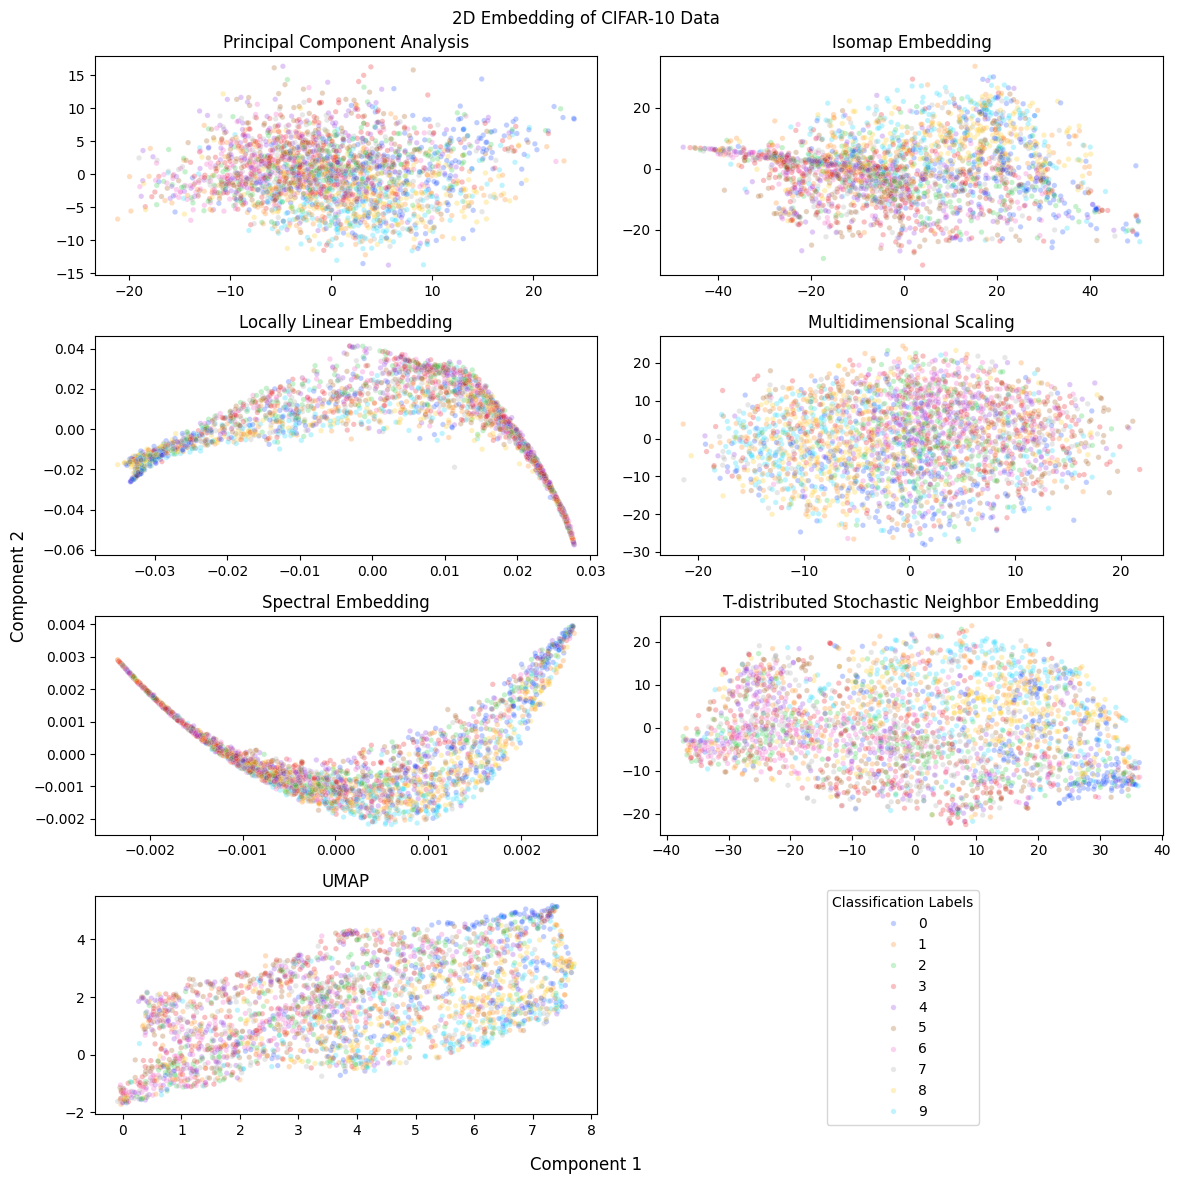

In [26]:
#plotting
subplots_2D(x_dict,y_train)

### Conclusions

In general, looking at the 2D embeddings above, we can see that the different dimensionality reduction techniques do generally group the different classes together. For example, class 0 is generally grouped together; however, it is also apparent that two dimensions is likely too low of a dimensionality for the data to be more clearly separated. Viewing this information in three dimensions will likely result in better groupings of distinct classes.

In addition, different classes are easier to separate from other classes. This is likely due to the images of that particular class being more similar to each other and the whole class being more different than the other classes. Given these characteristics, these different dimensionality reduction techniques would be more successful in grouping the like images together and representing that in a lower dimensional space.